Final Project: Neutron Diffusion

FTCS 2D Neutron Diffusion

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def normal(x,y,sigma):
    return (np.exp(-(x*x+y*y)/(2*sigma*sigma)))/(sigma*np.sqrt(2*np.pi))

#physical constants
C = 1
D = 1
#lattice size constants
N=50
Nx=N
Ny=N

L=10

Tmax=30


#boundary condition type
boundType=1 #0 for value, 1 for derivative
schemeType=0 # 0 for FTCS, 1 for LAX



if schemeType == 0:
    schemeName="FTCS"
elif schemeType ==1:
    schemeName="LAX"

if boundType ==0:
    boundName = "Boundaries: $n(x,y,t) = 0$"
elif boundType ==1:
    boundName= "Boundaries: $\\frac{\partial n(x,y,t)}{\partial x, y} = 0$"


#Value based boundary conditions
if boundType == 0:
    x_ind=np.arange(Nx+2)# vector of 0 to Nx inclusive
    y_ind=np.arange(Ny+2)#vector of 0 to Nx inclusive
    hx=L/(Nx+1)
    hy=L/(Ny+1)
    x=-L/2 + x_ind*hx
    y=-L/2 + y_ind*hy
    boundval=0



# Derivative-based boundary conditions
if boundType == 1:
    x_ind=np.arange(Nx+2)# vector of 0 to Nx+1 inclusive
    y_ind=np.arange(Ny+2)#vector of 0 to Nx+1 inclusive
    hx=L/Nx
    hy=L/Ny
    x= -L/2 +(x_ind-1/2)*hx
    y= -L/2 +(y_ind-1/2)*hy
    #the value for the derivative on the boundaries is set to zero


#numerical scheme constants
tau = 0.01
if schemeType == 0:
    stabletau= hx*hy/(2*D)
elif schemeType ==1:
    stabletau=hx*hy/(2*D)
    #this is not the correct stability tau for LAX

if tau > stabletau:
    tau = stabletau*0.5
max_timestep=int(np.ceil(Tmax/tau))

# iterate 1 to Nx when loopin

grid=np.zeros((Nx+2,Ny+2))


Cgrid=np.ones((Nx+2,Ny+2))*C

#set up grid initial conditions
xp, yp = np.meshgrid(x, y)
grid=normal(xp,yp,1)

evolution=np.zeros((Nx+2,Ny+2,max_timestep))
evolution[:,:,0]=grid
if boundType ==0:
    grid[:,0]=boundval
    grid[:,-1]=boundval
    grid[0,:]=boundval
    grid[-1,:]=boundval

for timestep in range(1,max_timestep):
    if boundType ==1:
        grid[:,0]=grid[:,1]
        grid[:,-1]=grid[:,-2]
        grid[0,:]=grid[1,:]
        grid[-1,:]=grid[-2,:]
        #the value for the derivative on the boundaries is set to zero
        evolution[:,:,timestep]=grid #update boundary values for record
    for i in range(1,Nx+1):
        for j in range(1,Ny+1):
            if schemeType == 0:
                #FTCS step
                evolution[i,j,timestep]=grid[i,j]+D*tau*((grid[i+1,j]+grid[i-1,j]-2*grid[i,j])/(hx*hx)+(grid[i,j+1]+grid[i,j-1]-2*grid[i,j])/(hy*hy))+Cgrid[i,j]*tau*grid[i,j]
            elif schemeType == 1:
                laxavg=(grid[i+1,j]+grid[i-1,j]+grid[i,j+1]+grid[i,j-1])/4
                evolution[i,j,timestep]=laxavg+D*tau*((grid[i+1,j]+grid[i-1,j]-2*laxavg)/(hx*hx)+(grid[i,j+1]+grid[i,j-1]-2*laxavg)/(hy*hy))+Cgrid[i,j]*tau*laxavg
                #lax step
    grid=np.copy(evolution[:,:,timestep])



Text(0.5, 0.92, 'FTCS Neutron Density at time 1.0, with Boundaries: $\\frac{\\partial n(x,y,t)}{\\partial x, y} = 0$ ')

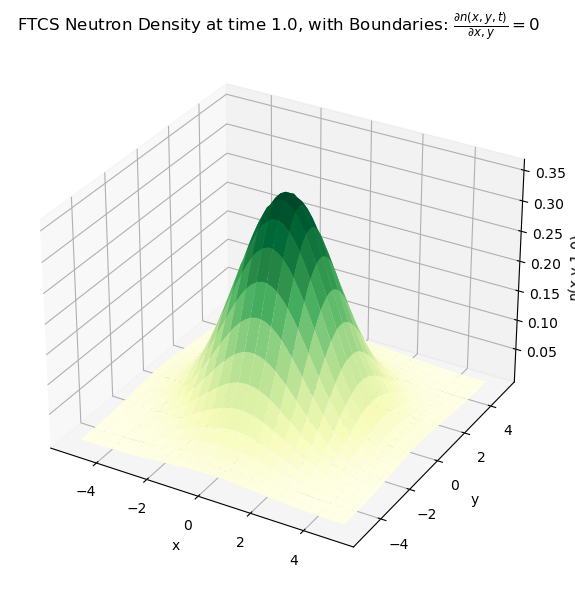

In [36]:
t_slice_index=100
timeslice=t_slice_index*tau
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
xp, yp = np.meshgrid(x, y)

ax.plot_surface(xp, yp, evolution[:,:,t_slice_index], rstride=2, cstride=2, cmap='YlGn')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(f'n(x,y,{timeslice})')
ax.set_title(f'{schemeName} Neutron Density at time {timeslice}, with {boundName} ')

LAX 2D Neutron Diffusion


In [37]:
import numpy as np
import matplotlib.pyplot as plt

def normal(x,y,sigma):
    return (np.exp(-(x*x+y*y)/(2*sigma*sigma)))/(sigma*np.sqrt(2*np.pi))

#physical constants
C = 1
D = 1
#lattice size constants
N=50
Nx=N
Ny=N

L=10

Tmax=30


#boundary condition type
boundType=1 #0 for value, 1 for derivative

#Value based boundary conditions
if boundType == 0:
    x_ind=np.arange(Nx+2)# vector of 0 to Nx inclusive
    y_ind=np.arange(Ny+2)#vector of 0 to Nx inclusive
    hx=L/(Nx+1)
    hy=L/(Ny+1)
    x=-L/2 + x_ind*hx
    y=-L/2 + y_ind*hy
    boundval=0



# Derivative-based boundary conditions
if boundType == 1:
    x_ind=np.arange(Nx+2)# vector of 0 to Nx+1 inclusive
    y_ind=np.arange(Ny+2)#vector of 0 to Nx+1 inclusive
    hx=L/Nx
    hy=L/Ny
    x= -L/2 +(x_ind-1/2)*hx
    y= -L/2 +(y_ind-1/2)*hy



#numerical scheme constants
tau = 0.01

stabletau= hx*hy/(2*D)
#stability analysis not done, this is the bound from FTCS, so it does not reflect actual stability


if tau > stabletau:
    tau = stabletau*0.5
max_timestep=int(np.ceil(Tmax/tau))

# iterate 1 to Nx when loopin

grid=np.zeros((Nx+2,Ny+2))


Cgrid=np.ones((Nx+2,Ny+2))*C

#set up grid initial conditions
xp, yp = np.meshgrid(x, y)
grid=normal(xp,yp,1)

evolution=np.zeros((Nx+2,Ny+2,max_timestep))
evolution[:,:,0]=grid
if boundType ==0:
    grid[:,0]=boundval
    grid[:,-1]=boundval
    grid[0,:]=boundval
    grid[-1,:]=boundval
for timestep in range(1,max_timestep):
    if boundType ==1:
        grid[:,0]=grid[:,1]
        grid[:,-1]=grid[:,-2]
        grid[0,:]=grid[1,:]
        grid[-1,:]=grid[-2,:]
        #the value for the derivative on the boundaries is set to zero
        evolution[:,:,timestep]=grid #update boundary values for record
    for i in range(1,Nx+1):
        for j in range(1,Ny+1):
            laxavg=(grid[i+1,j]+grid[i-1,j]+grid[i,j+1]+grid[i,j-1])/4
            evolution[i,j,timestep]=laxavg+D*tau*((grid[i+1,j]+grid[i-1,j]-2*laxavg)/(hx*hx)+(grid[i,j+1]+grid[i,j-1]-2*laxavg)/(hy*hy))+Cgrid[i,j]*tau*laxavg
            #lax step
    grid=np.copy(evolution[:,:,timestep])



Text(0.5, 0.92, 'LAX Neutron Density at time 16.0')

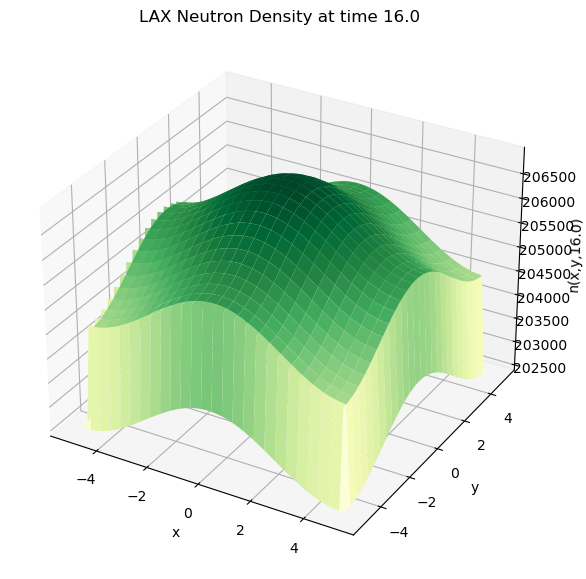

In [38]:
t_slice_index=1600
timeslice=t_slice_index*tau
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
xp, yp = np.meshgrid(x, y)

ax.plot_surface(xp, yp, evolution[:,:,t_slice_index], rstride=2, cstride=2, cmap='YlGn')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(f'n(x,y,{timeslice})')
ax.set_title(f'LAX Neutron Density at time {timeslice}')